<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-04-30 21:51:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.07s   

2021-04-30 21:51:46 (302 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!pip install seaborn

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


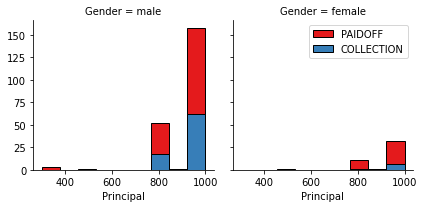

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

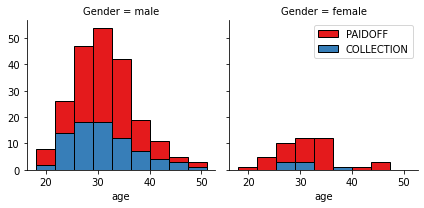

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

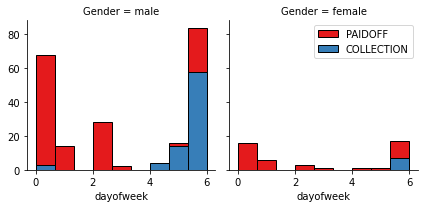

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [22]:
from sklearn.neighbors import KNeighborsClassifier as knn

mean_accuracy = []

for n in range(1, 10):
    knn_model  = knn(n_neighbors = n)
    knn_model.fit(X_train, y_train)
    knn_yhat = knn_model.predict(X_test)
    mean_accuracy.append(accuracy_score(y_test, knn_yhat))

k = 1 has a score = 0.6571428571428571
k = 2 has a score = 0.5714285714285714
k = 3 has a score = 0.6571428571428571
k = 4 has a score = 0.6142857142857143
k = 5 has a score = 0.7571428571428571
k = 6 has a score = 0.6714285714285714
k = 7 has a score = 0.7285714285714285
k = 8 has a score = 0.6428571428571429
k = 9 has a score = 0.6857142857142857


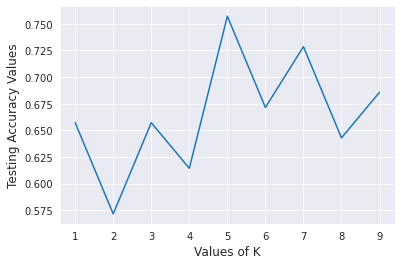

In [23]:
for i in range(0, len(mean_accuracy)):
    print("k = {} has a score = {}".format(i+1, mean_accuracy[i]))

sns.set_style("darkgrid")
plt.plot(range(1, 10), mean_accuracy)
plt.xlabel('Values of K', fontsize = 12)
plt.ylabel('Testing Accuracy Values', fontsize = 12)
plt.show()

In [29]:
neigh_ = knn(n_neighbors = 5)
neigh_.fit(X_train, y_train)
yhat_knn = neigh_.predict(X_test)

neigh_

KNeighborsClassifier()

# Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

mean_accuracy = []

for d in range(1, 10):
    dt = DecisionTreeClassifier(criterion = 'gini', max_depth = d)
    dt.fit(X_train, y_train)
    dt_yhat = dt.predict(X_test)
    mean_accuracy.append(f1_score(y_test, dt_yhat, average = 'weighted', pos_label = 'PAIDOFF'))

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1270: UserWarning: Note that pos_label (set to 'PAIDOFF') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1270: UserWarning: Note that pos_label (set to 'PAIDOFF') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1270: UserWarning: Note that pos_label (set to 'PAIDOFF') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/s

d = 0 has a f1 score = 0.671889400921659
d = 1 has a f1 score = 0.671889400921659
d = 2 has a f1 score = 0.671889400921659
d = 3 has a f1 score = 0.6614571868809157
d = 4 has a f1 score = 0.7085714285714285
d = 5 has a f1 score = 0.6919930236245441
d = 6 has a f1 score = 0.618883157658668
d = 7 has a f1 score = 0.605144855144855
d = 8 has a f1 score = 0.5923645862839518


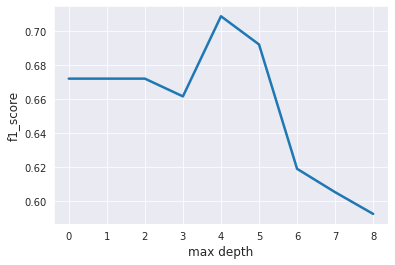

In [26]:
for i in range(0, len(mean_accuracy)):
    print('d = {} has a f1 score = {}'.format(i+0, mean_accuracy[i]))

sns.set_style("darkgrid")
sns.lineplot(x = range(0, 9), y = mean_accuracy, linewidth = 2.5)
plt.ylabel('f1_score', fontsize = 12)
plt.xlabel('max depth', fontsize = 12)
plt.show()

In [30]:
tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 4)
tree.fit(X_train, y_train)
tree

DecisionTreeClassifier(max_depth=4)

# Support Vector Machine

In [31]:
from sklearn import svm

kernel_func = ['sigmoid', 'poly', 'rbf', 'linear']
mean_accuracy = []

for k in kernel_func:
    svc_model = svm.SVC(C = 0.01, gamma = 'auto', kernel = k)
    svc_model.fit(X_train, y_train)
    svc_yhat = svc_model.predict(X_test)
    mean_accuracy.append(f1_score(y_test, svc_yhat, pos_label = 'PAIDOFF'))

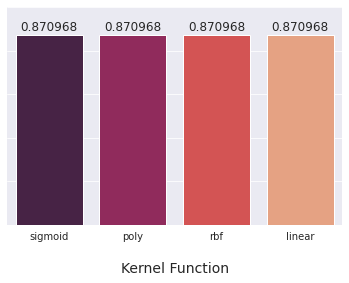

In [32]:
plots = sns.barplot(x = kernel_func, y = mean_accuracy, palette = 'rocket')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.6f'), (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha = 'center', va = 'center', size = 12, xytext = (0, 8), textcoords = 'offset points')
sns.despine(left = True, bottom = True)
sns.set_style('white')
plt.tick_params(labelleft = False, left = False)
plt.ylim([0, 1])
plt.xlabel("\nKernel Function", fontsize = 14)
plt.show()

In [33]:
clf = svm.SVC(C = 0.01, gamma = 'auto', kernel = 'poly')
clf.fit(X_train, y_train)
clf

SVC(C=0.01, gamma='auto', kernel='poly')

# Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
regularization_val = [0.1, 0.01, 0.001]
mean_logloss = []

for c in regularization_val:
    for solver in solvers:
        lr_model = LogisticRegression(C = c, solver = solver)
        lr_model.fit(X_train, y_train)
        lr_yhat = lr_model.predict_proba(X_test)
        score = log_loss(y_test, lr_yhat)
        print('Accuracy = {}    for C = {} and Solver = {}'.format(score, c, solver))
        mean_logloss.append(score)
    print('\n')

Accuracy = 0.49452638064613785    for C = 0.1 and Solver = liblinear
Accuracy = 0.4734306360124719    for C = 0.1 and Solver = newton-cg
Accuracy = 0.47343256956109536    for C = 0.1 and Solver = lbfgs
Accuracy = 0.4734246392093025    for C = 0.1 and Solver = sag
Accuracy = 0.4734305438601505    for C = 0.1 and Solver = saga


Accuracy = 0.5843302956467592    for C = 0.01 and Solver = liblinear
Accuracy = 0.5019749593529963    for C = 0.01 and Solver = newton-cg
Accuracy = 0.5019749819486685    for C = 0.01 and Solver = lbfgs
Accuracy = 0.501975081997907    for C = 0.01 and Solver = sag
Accuracy = 0.5019749879346384    for C = 0.01 and Solver = saga


Accuracy = 0.6726824378415988    for C = 0.001 and Solver = liblinear
Accuracy = 0.5324603013409366    for C = 0.001 and Solver = newton-cg
Accuracy = 0.5324602602128707    for C = 0.001 and Solver = lbfgs
Accuracy = 0.532459069721068    for C = 0.001 and Solver = sag
Accuracy = 0.5324591942260428    for C = 0.001 and Solver = saga




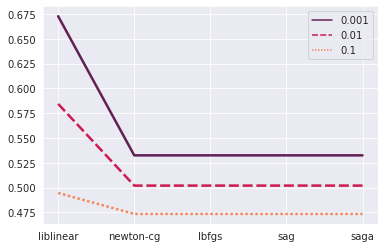

In [35]:
dictionary = {0.1: mean_logloss[0:5],
             0.01: mean_logloss[5:10],
             0.001: mean_logloss[10:15]}

sns.set_style("darkgrid")
sns.lineplot(data = pd.DataFrame.from_dict(dictionary), palette = "rocket", linewidth = 2.5)
plt.xticks([0.0, 1.0, 2.0, 3.0, 4.0], labels = solvers)
plt.show()

In [36]:
LR = LogisticRegression(C = 0.001, solver = 'liblinear')
LR.fit(X_train, y_train)
LR

LogisticRegression(C=0.001, solver='liblinear')

# Model Evaluation using Test set

First, download and load the test set:

In [37]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-04-30 21:54:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-04-30 21:54:02 (102 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [38]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [39]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

X_test_ = test_df[['Principal','terms','age','Gender', 'weekend']]
X_test_ = pd.concat([X_test_,pd.get_dummies(test_df['education'])], axis=1)
X_test_.drop(['Master or Above'], axis = 1,inplace=True)

X_test_ = preprocessing.StandardScaler().fit(X_test_).transform(X_test_)

y_test_ = test_df['loan_status'].values

print(X_test_[0:5])
print(y_test_[0:5])

[[ 0.49362588  0.92844966  3.05981865  1.97714211 -1.30384048  2.39791576
  -0.79772404 -0.86135677]
 [-3.56269116 -1.70427745  0.53336288 -0.50578054  0.76696499 -0.41702883
  -0.79772404 -0.86135677]
 [ 0.49362588  0.92844966  1.88080596  1.97714211  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588  0.92844966 -0.98251057 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [-0.66532184 -0.78854628 -0.47721942 -0.50578054  0.76696499  2.39791576
  -0.79772404 -0.86135677]]
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [40]:
# For KNN Algorithm

ytest_knn = neigh_.predict(X_test_)

jaccard_knn = jaccard_score(y_test_, ytest_knn, pos_label = 'PAIDOFF')
f1_knn = f1_score(y_test_, ytest_knn, pos_label = 'PAIDOFF')

print("jaccard score for KNN = ", jaccard_knn)
print("F1 score for KNN = ", f1_knn)

jaccard score for KNN =  0.6326530612244898
F1 score for KNN =  0.775


In [41]:
# For Decision Tree Algorithm

ytest_tree = tree.predict(X_test_)

jaccard_tree = jaccard_score(y_test_, ytest_tree, pos_label = 'PAIDOFF')
f1_tree = f1_score(y_test_, ytest_tree, pos_label = 'PAIDOFF')

print("jaccard score for Decision Tree = ", jaccard_tree)
print("F1 score for Decision Tree = ", f1_tree)

jaccard score for Decision Tree =  0.7169811320754716
F1 score for Decision Tree =  0.8351648351648352


In [42]:
# For SVM Algorithm

ytest_svm = clf.predict(X_test_)

jaccard_svm = jaccard_score(y_test_, ytest_svm, pos_label = 'PAIDOFF')
f1_svm = f1_score(y_test_, ytest_svm, pos_label = 'PAIDOFF')

print("jaccard score for SVM = ", jaccard_svm)
print("F1 score for SVM = ", f1_svm)

jaccard score for SVM =  0.7407407407407407
F1 score for SVM =  0.851063829787234


In [43]:
# For Logistic Regression Algorithm

ytest_lr = LR.predict(X_test_)
ytest_lr_ = LR.predict_proba(X_test_)

jaccard_lr = jaccard_score(y_test_, ytest_lr, pos_label = 'PAIDOFF')
f1_lr = f1_score(y_test_, ytest_lr, pos_label = 'PAIDOFF')
logloss = log_loss(y_test_, ytest_lr_)

print("jaccard score for LR = ", jaccard_lr)
print("F1 score for LR = ", f1_lr)
print("Log-Loss for LR = ", logloss)

jaccard score for LR =  0.6730769230769231
F1 score for LR =  0.8045977011494252
Log-Loss for LR =  0.6701108000104924


In [44]:
Report = {'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression'],
         'Jaccard': [jaccard_knn, jaccard_tree, jaccard_svm, jaccard_lr],
         'F1-score': [f1_knn, f1_tree, f1_svm, f1_lr],
         'LogLoss': ['NA', 'NA', 'NA', logloss]}

Report_df = pd.DataFrame.from_dict(Report)

Report_df

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.632653,0.775000,NA
1,Decision Tree,0.716981,0.835165,NA
2,SVM,0.740741,0.851064,NA
3,Logistic Regression,0.673077,0.804598,0.670111


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>